In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import glob
import keras
import random
import tensorflow as tf
from keras.layers import *
import keras.backend as k
from keras.models import *
from keras.optimizers import *
from skimage.transform import resize
from skimage.io import imread, imshow, imsave
from keras.losses import categorical_crossentropy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from skimage.metrics import peak_signal_noise_ratio
from skimage.restoration import (denoise_wavelet , estimate_sigma)
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.metrics import Recall, Precision
from sklearn.metrics import confusion_matrix
import gc
from tqdm import tqdm
from PIL import Image

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [3]:
Data_dir = "/content/drive/MyDrive/Dataset_BUSI_with_GT"
folders = os.listdir(Data_dir)
folders

['malignant', 'benign', 'normal']

In [4]:
image_paths, labels, mask_paths = [], [], []

for folder in folders:
    files = os.listdir(os.path.join(Data_dir, folder))
    for file in files:
        if "mask_" in file:
            continue
        elif "mask" in file:
            mask_paths.append(os.path.join(Data_dir, folder, file))
        else:
            image_paths.append(os.path.join(Data_dir, folder, file))
            labels.append(folder)

In [5]:
df = pd.DataFrame({"image_path": image_paths, "mask_path": mask_paths,"label": labels})
df.head()

,image_path,mask_path,label
0,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...,malignant
1,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...,malignant
2,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...,malignant
3,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...,malignant
4,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...,malignant


In [6]:
df["label"].value_counts()

label
benign       437
malignant    210
normal       133
Name: count, dtype: int64

In [7]:
def preprocess_images_and_masks(folder_path):

  # Sort the list of filenames
  filenames = sorted(os.listdir(folder_path))

  # Load the images and masks from the folder
  # Taking out multiple masks for one image because I am a coward
  images = [cv2.imread(os.path.join(folder_path, f)) for f in filenames if f.endswith('.png') and not (f.endswith('_mask.png') or f.endswith('_mask_1.png') or f.endswith('_mask_2.png'))]
  masks = [cv2.imread(os.path.join(folder_path, f), cv2.IMREAD_GRAYSCALE) for f in filenames if f.endswith('_mask.png')]

  # Resize the images and masks to a desired size
  desired_size = (256, 256)
  images = [cv2.resize(image, desired_size) for image in images]
  masks = [cv2.resize(mask, desired_size, interpolation=cv2.INTER_NEAREST) for mask in masks]

  # Convert the images to RGB format (if they are not already)
  images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images]

  # Normalize the pixel values of the images and masks
  images = [image / 255.0 for image in images]
  masks = [mask / 255.0 for mask in masks]

  # Convert the images and masks to numpy arrays
  images = np.array(images)
  masks = np.array(masks)

  return images, masks

In [8]:
# Define the paths to the three folders
benign_folder = '/content/drive/MyDrive/Dataset_BUSI_with_GT/benign'
malignant_folder = '/content/drive/MyDrive/Dataset_BUSI_with_GT/malignant'
normal_folder = '/content/drive/MyDrive/Dataset_BUSI_with_GT/normal'

# Preprocess the images and masks from the folders
benign_images, benign_masks = preprocess_images_and_masks(benign_folder)
malignant_images, malignant_masks = preprocess_images_and_masks(malignant_folder)
normal_images, normal_masks = preprocess_images_and_masks(normal_folder)

# Concatenate the images and masks from the three folders
images = np.concatenate((benign_images, malignant_images, normal_images), axis=0)
masks = np.concatenate((benign_masks, malignant_masks, normal_masks), axis=0)

In [9]:
# Check the dimensions of the images and masks arrays
if len(images) == 0 or len(masks) == 0:
  print("Error: Images or masks array is empty")
elif len(images) != len(masks):
  print("Error: Mismatch in number of images and masks")
else:
  # Shuffle the images and masks together
  combined = list(zip(images, masks))
  np.random.shuffle(combined)
  images, masks = zip(*combined)

  # Convert the images and masks to numpy arrays
  images = np.array(images)
  masks = np.array(masks)

  # Calculate the number of images in each split
  num_images = len(images)
  num_train = int(0.90 * num_images)
  num_val = int(0.075 * num_images)
  num_test = num_images - num_train - num_val

  # Split the images and masks into training, validation, and test sets
  train_images = images[:num_train]
  train_masks = masks[:num_train]
  val_images = images[num_train:num_train+num_val]
  val_masks = masks[num_train:num_train+num_val]
  test_images = images[num_train+num_val:]
  test_masks = masks[num_train+num_val:]

**Train Shape:**

In [10]:
print(np.shape(train_images))
print(np.shape(train_masks))

(702, 256, 256, 3)
(702, 256, 256)


**Test Shape:**

In [11]:
print(np.shape(test_images))
print(np.shape(test_masks))

(20, 256, 256, 3)
(20, 256, 256)


**Validation Shape:**

In [12]:
print(np.shape(val_images))
print(np.shape(val_masks))

(58, 256, 256, 3)
(58, 256, 256)


**Display the image and the true mask (Benign):**

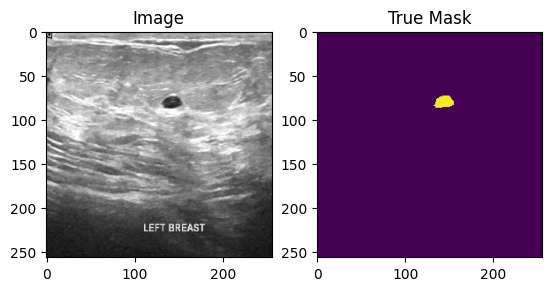

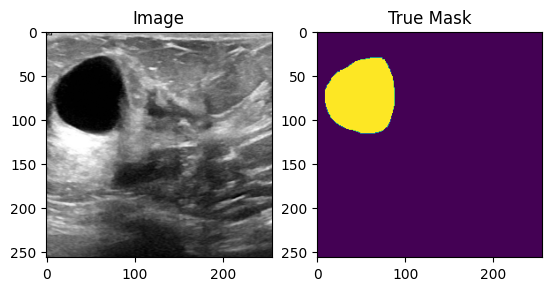

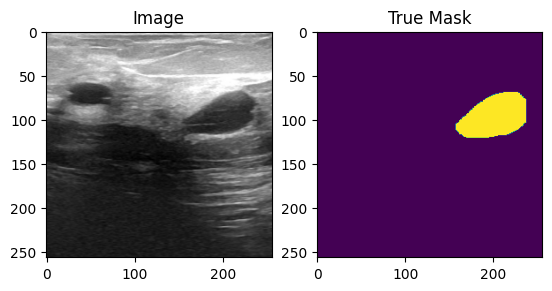

In [13]:
for i in range(3):
    image = benign_images[i]
    mask = benign_masks[i]

    # Display the image and the true mask
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image)
    ax1.set_title("Image")
    ax2.imshow(mask)
    ax2.set_title("True Mask")

    plt.show()

**Display the image and the true mask (Malignant):**

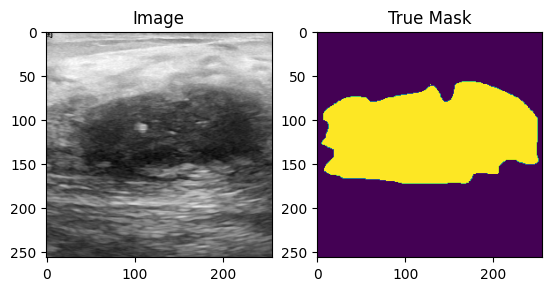

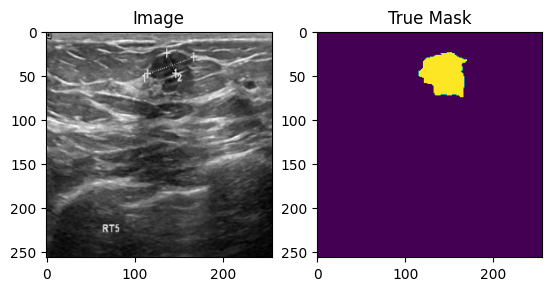

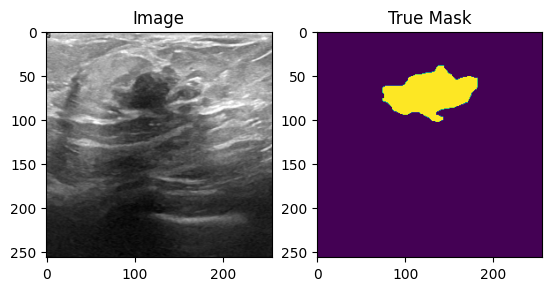

In [18]:
for i in range(3):
    image = malignant_images[i]
    mask = malignant_masks[i]

    # Display the image and the true mask
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image)
    ax1.set_title("Image")
    ax2.imshow(mask)
    ax2.set_title("True Mask")

    plt.show()

**Display the image and the true mask (Normal):**

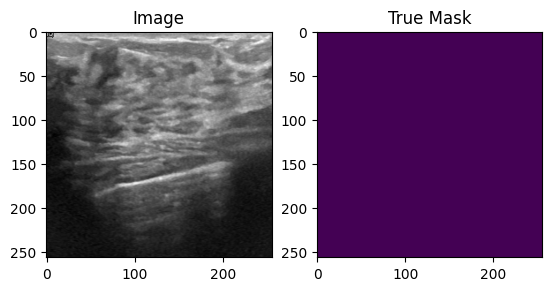

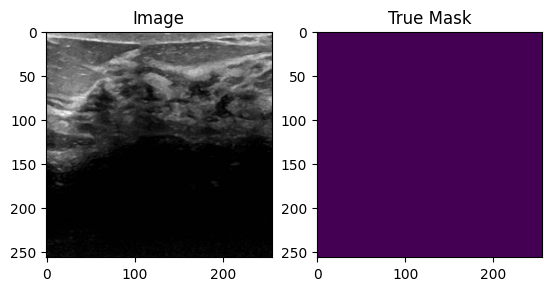

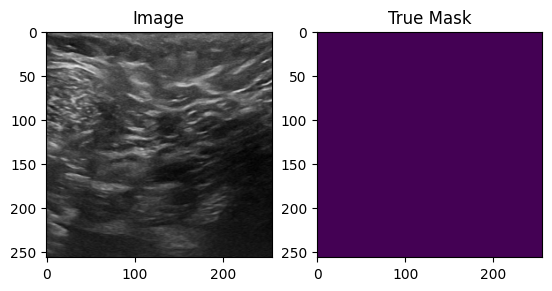

In [19]:
for i in range(3):
    image = normal_images[i]
    mask = normal_masks[i]

    # Display the image and the true mask
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image)
    ax1.set_title("Image")
    ax2.imshow(mask)
    ax2.set_title("True Mask")

    plt.show()

In [14]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [15]:
def IOU(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection/union

In [16]:
ini_input=keras.Input(shape=(256,256,3),name="image")
#n = Lambda(lambda x: x/127.5 - 1.)(ini_input)


c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(ini_input)
#c1 = layers.Dropout(0.1)(c1)
c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c1)
p1 = MaxPooling2D((2,2))(c1)


c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p1)
#c2 = layers.Dropout(0.1)(c2)
c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c2)
p2 = MaxPooling2D((2,2))(c2)


c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p2)
#c3 = layers.Dropout(0.1)(c3)
c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c3)
p3 = MaxPooling2D((2,2))(c3)


c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p3)
#c4 = layers.Dropout(0.1)(c4)
c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c4)
p4 = MaxPooling2D((2,2))(c4)


c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p4)
#c5 = layers.Dropout(0.1)(c5)
c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c5)



u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u6)
#c6 = layers.Dropout(0.1)(c6)
c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c6)


u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u7)
#c7 = layers.Dropout(0.1)(c7)
c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c7)

u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u8)
#c8 = layers.Dropout(0.1)(c8)
c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c8)


u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9 = concatenate([u9, c1], axis = 3)
c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u9)
#c9 = layers.Dropout(0.1)(c9)
c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c9)

outputs = Conv2D(1,(1,1), activation='sigmoid')(c9)

model1 = Model(inputs = [ini_input], outputs = [outputs])

In [17]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['image[0][0]']               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [23]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 20.3 MB/s eta 0:00:00


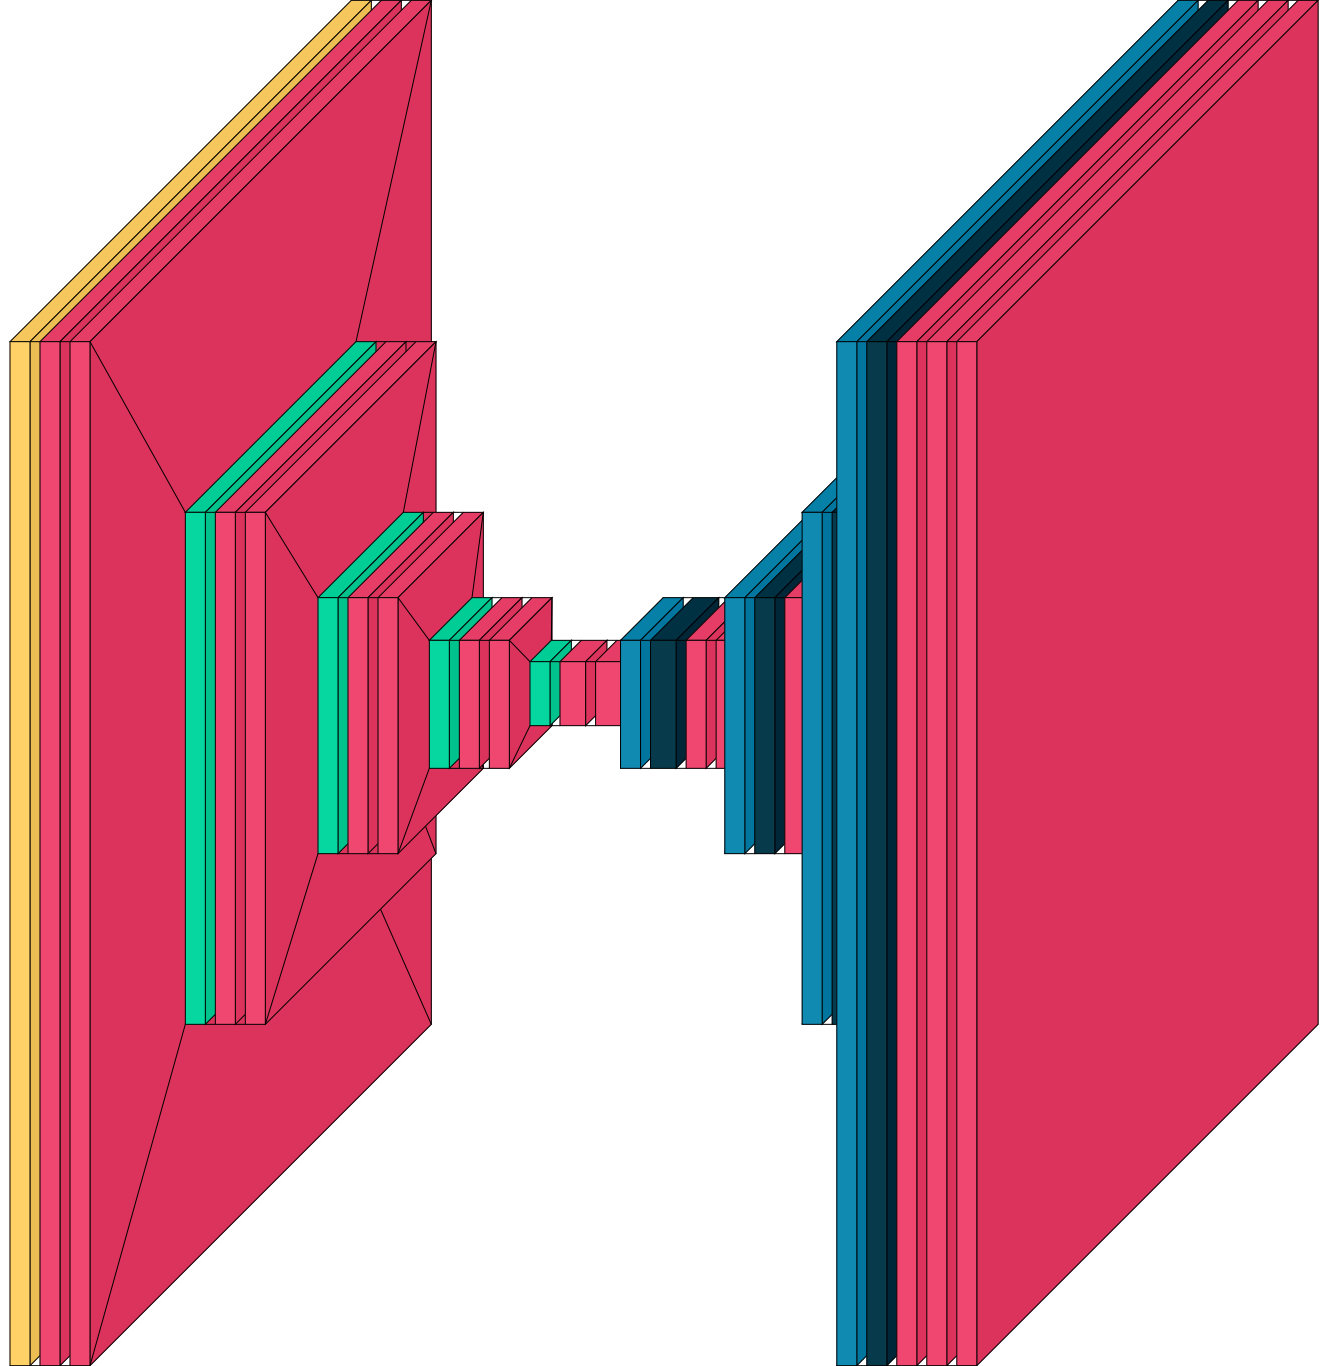

In [24]:
import visualkeras
visualkeras.layered_view(model1, legend=True) # without custom font
from PIL import ImageFont
#font = ImageFont.truetype("arial.ttf", 12)
visualkeras.layered_view(model1) # selected font

In [18]:
def dice_loss(y_true, y_pred):
    # Flatten the predictions and ground truth
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])

    # Compute the intersection and union
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)

    # Compute the Dice loss
    dice_loss = 1 - 2 * intersection / union

    return dice_loss

In [19]:
from keras import backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [20]:
model1.compile(optimizer=Adam(learning_rate=1e-4), loss = dice_loss, metrics = [dice_coef, Recall(), Precision(), 'accuracy', f1_score ])

In [21]:
history1 = model1.fit(train_images, train_masks, batch_size=2, epochs=100, verbose=1, validation_data=(val_images, val_masks))

Epoch 1/100
351/351 [==============================] - 23s 23ms/step - loss: 0.8247 - dice_coef: 0.1753 - recall: 0.7466 - precision: 0.1015 - accuracy: 0.4810 - f1_score: 0.1855 - val_loss: 0.5976 - val_dice_coef: 0.4024 - val_recall: 0.3869 - val_precision: 0.4960 - val_accuracy: 0.8969 - val_f1_score: 0.4062
Epoch 2/100
351/351 [==============================] - 7s 21ms/step - loss: 0.6415 - dice_coef: 0.3585 - recall: 0.5252 - precision: 0.2993 - accuracy: 0.8710 - f1_score: 0.3598 - val_loss: 0.5030 - val_dice_coef: 0.4970 - val_recall: 0.4238 - val_precision: 0.6130 - val_accuracy: 0.9136 - val_f1_score: 0.4980
Epoch 3/100
351/351 [==============================] - 7s 21ms/step - loss: 0.5828 - dice_coef: 0.4172 - recall: 0.4678 - precision: 0.4240 - accuracy: 0.9117 - f1_score: 0.4174 - val_loss: 0.4742 - val_dice_coef: 0.5258 - val_recall: 0.6697 - val_precision: 0.5176 - val_accuracy: 0.9022 - val_f1_score: 0.5257
Epoch 4/100
351/351 [==============================] - 7s 21ms/

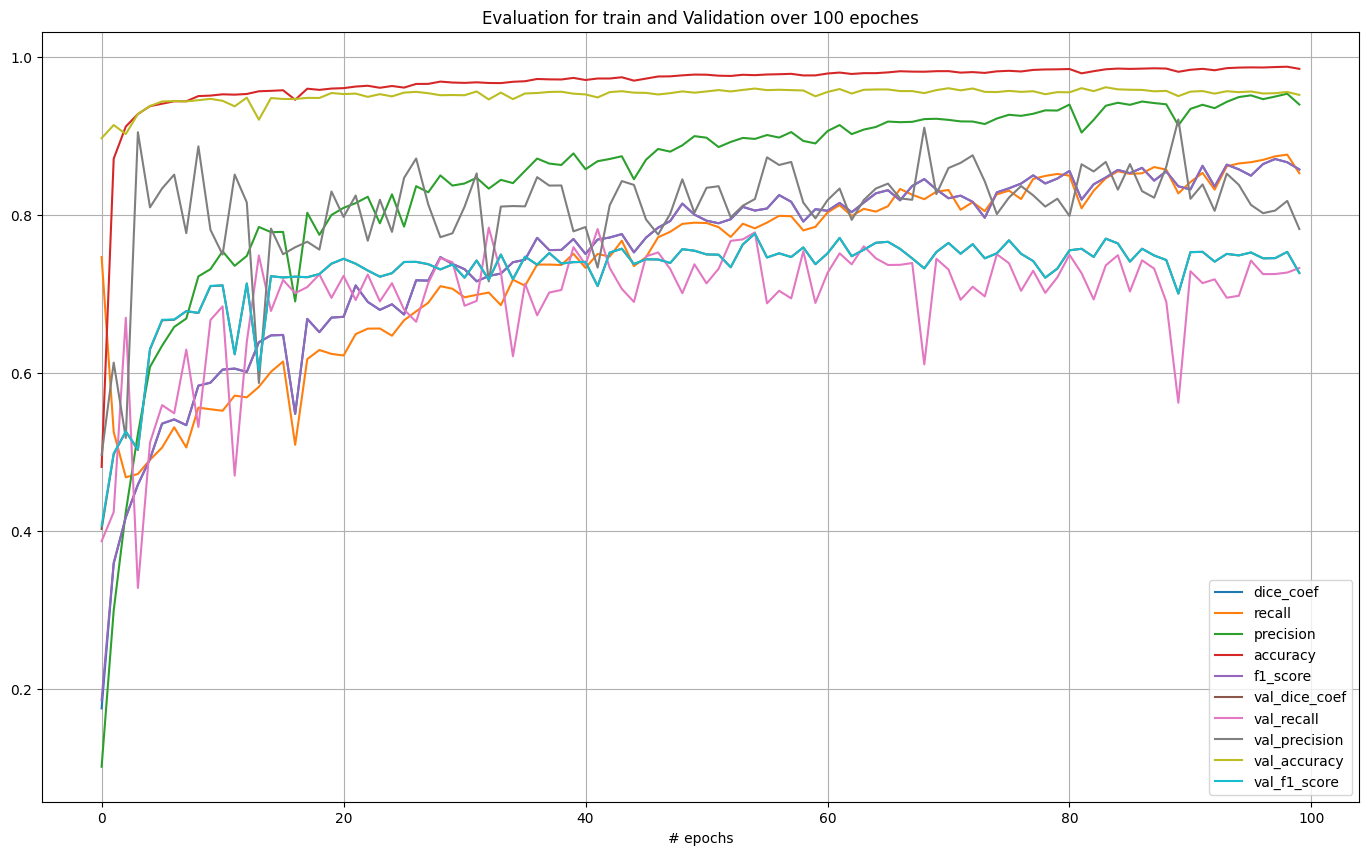

In [22]:
keys = history1.history.keys()
l = []
plt.figure(figsize=(17, 10))
for key in keys:
    if key[-1] != 's':
        plt.plot(history1.history[key])
        l.append(key)
plt.grid()
plt.legend(l)
plt.title('Evaluation for train and Validation over 100 epoches')
plt.xlabel('# epochs');

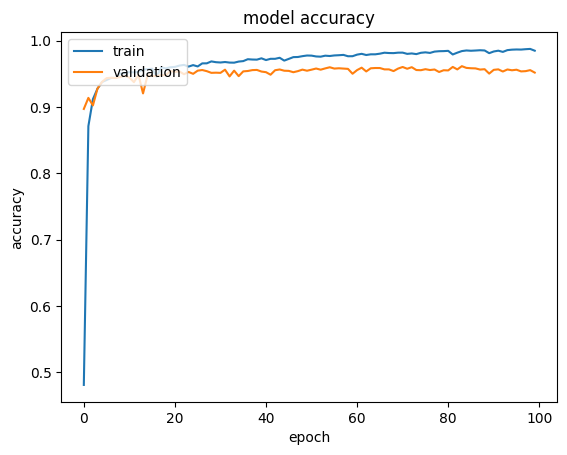

In [23]:
#  "accuracy"
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

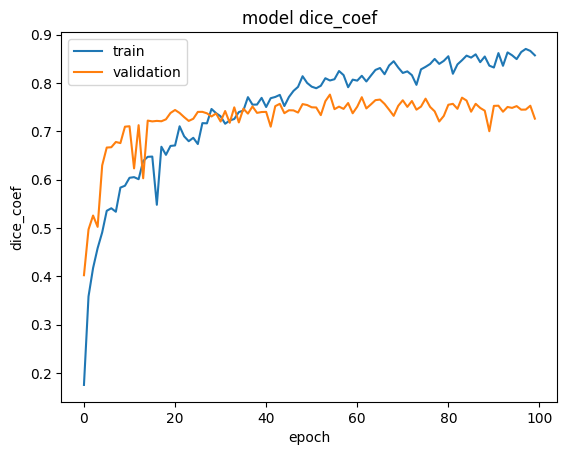

In [24]:
#  "dice_coef"
plt.plot(history1.history['dice_coef'])
plt.plot(history1.history['val_dice_coef'])
plt.title('model dice_coef')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

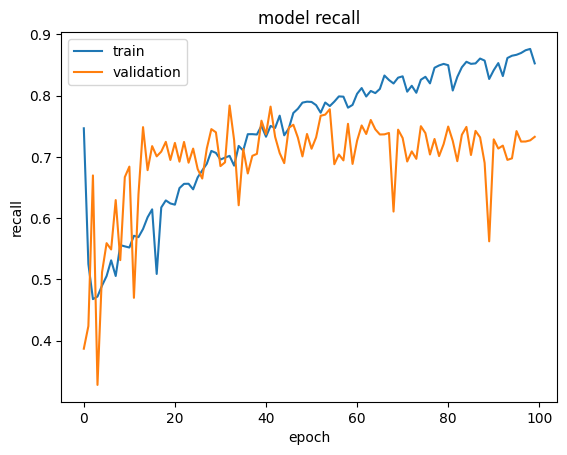

In [27]:
#  "recall"
plt.plot(history1.history['recall'])
plt.plot(history1.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

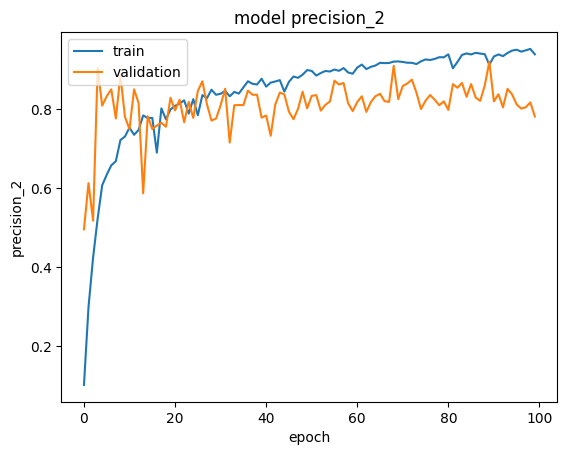

In [28]:
#  "precision"
plt.plot(history1.history['precision'])
plt.plot(history1.history['val_precision'])
plt.title('model precision_2')
plt.ylabel('precision_2')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

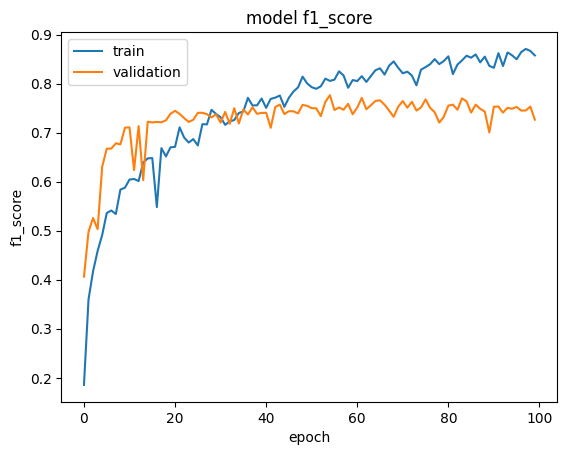

In [29]:
#  "f1_score"
plt.plot(history1.history['f1_score'])
plt.plot(history1.history['val_f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

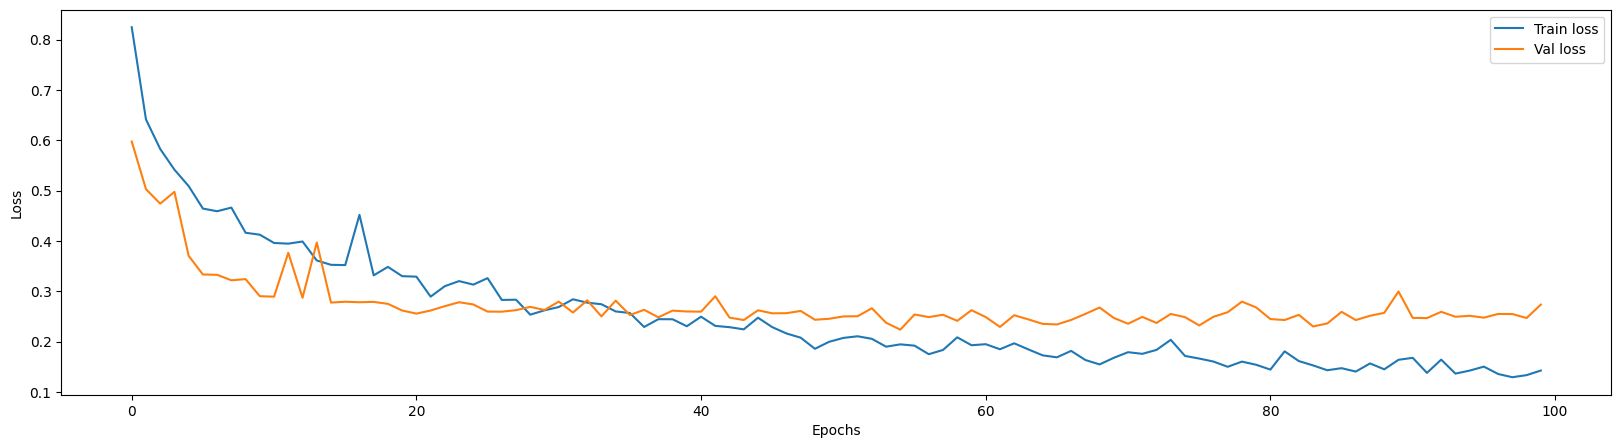

In [30]:
plt.figure(figsize=(20, 5))
plt.plot(model1.history.history['loss'], label='Train loss')
plt.plot(model1.history.history['val_loss'], label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [31]:
score = model1.evaluate(test_images, test_masks, verbose = 1)

1/1 [==============================] - 4s 4s/step - loss: 0.2826 - dice_coef: 0.7174 - recall: 0.7536 - precision: 0.6847 - accuracy: 0.9662 - f1_score: 0.7175


In [32]:
preds_test = model1.predict(test_images, verbose=1)
preds_test_t = (preds_test>(0.5)).astype(np.uint8)

1/1 [==============================] - 0s 412ms/step


In [45]:
Z = 2

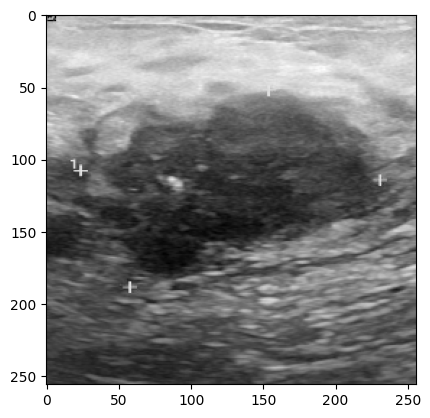

In [46]:
plt.imshow(test_images[Z].reshape(256,256,3),cmap='gray')

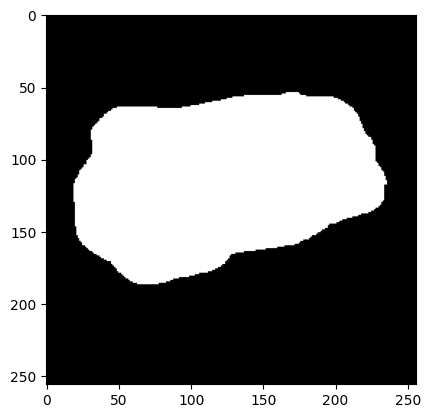

In [47]:
plt.imshow(test_masks[Z].reshape(256,256,1),cmap='gray')

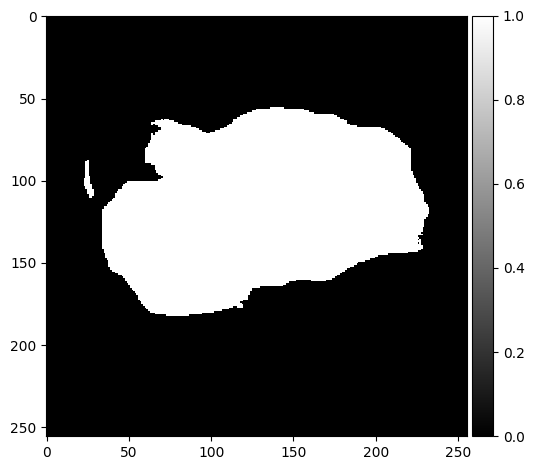

In [48]:
imshow((preds_test_t[Z]).reshape(256,256), cmap = 'gray')

<ipython-input-49-afacbeb5f44a>:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


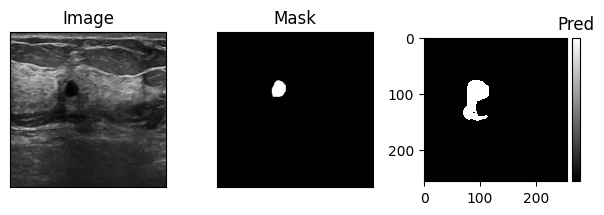

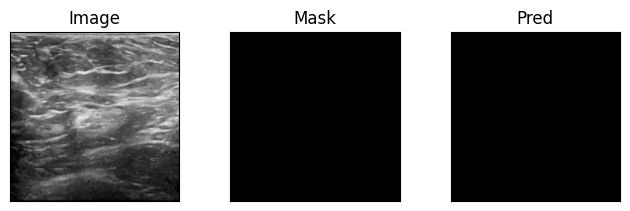

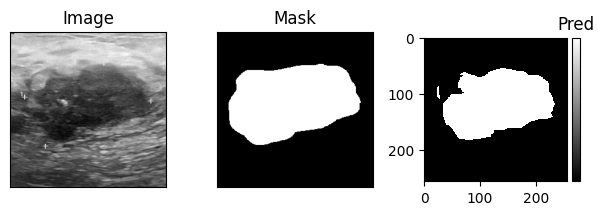

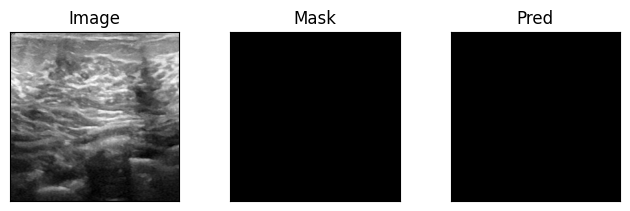

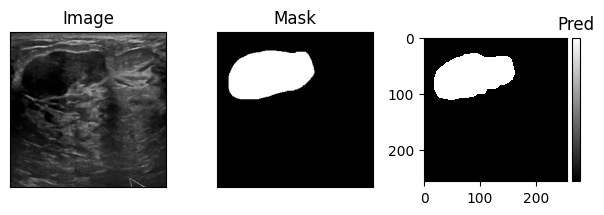

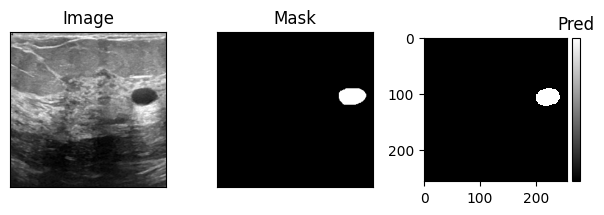

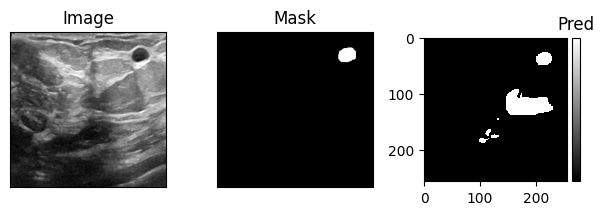

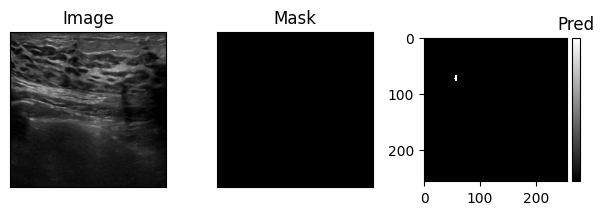

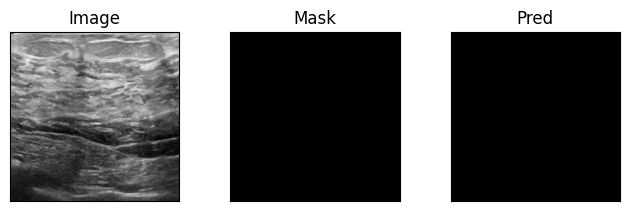

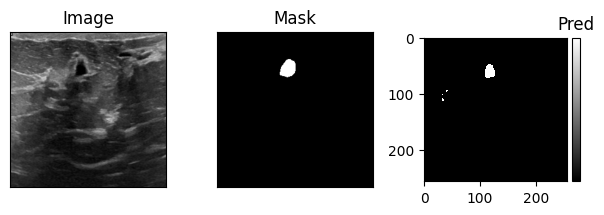

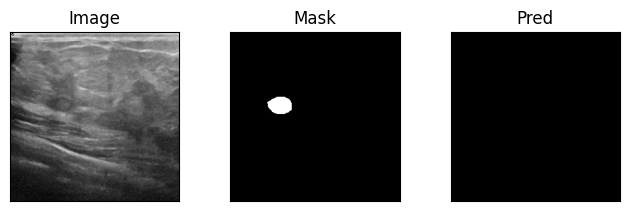

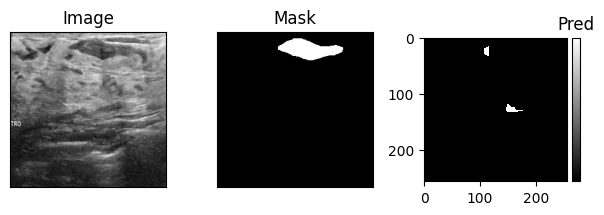

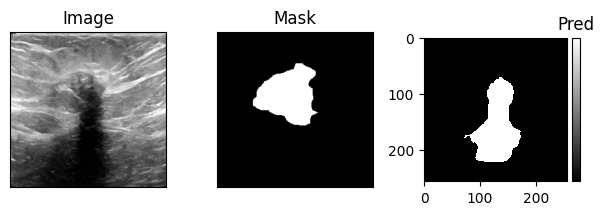

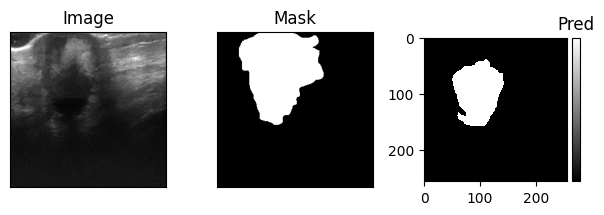

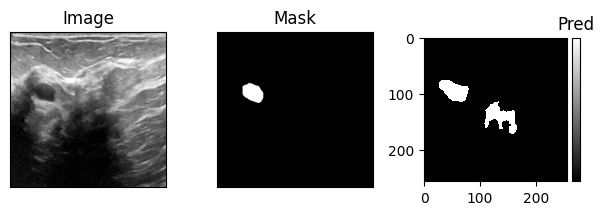

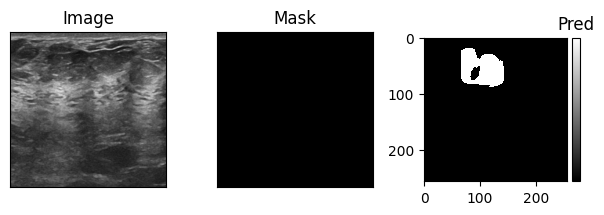

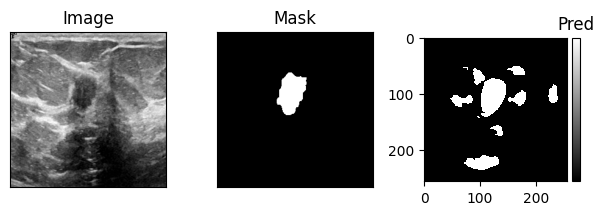

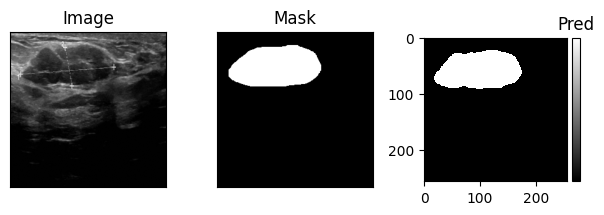

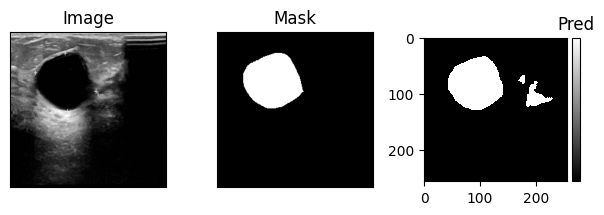

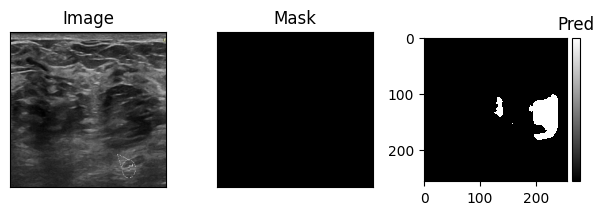

<Figure size 640x480 with 0 Axes>

In [49]:
for i in range(20):
  plt.subplot(1,3,1)
  r = i
  plt.imshow(test_images[r].reshape(256,256,3),cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.title("Image")

  plt.subplot(1,3,2)
  plt.imshow(test_masks[r].reshape(256,256,1),cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.title("Mask")

  plt.subplot(1,3,3)
  imshow((preds_test_t[r]).reshape(256,256,1), cmap = 'gray')
  plt.xticks([])
  plt.yticks([])
  plt.title("Pred")

  plt.figure()